This notebook merges the data into a consistent xarray object. 

In [9]:
import xarray as xr
import rioxarray
import geopandas as gpd
from rasterio import features
import numpy as np

Starting with some key variables that will be used throughout the script. 

In [10]:
martinique_shape = True

In [46]:
def binary_vector_to_raster(input_vector, layer_name, reference):

    shape = (reference.sizes["y"], reference.sizes["x"])
    transform = reference.rio.transform()

    geom = [shapes for shapes in input_vector.geometry]

    # Rasterize vector using the shape and coordinate system of the raster
    rasterized = features.rasterize(geom,
                                out_shape = shape,
                                fill = 0,
                                out = None,
                                transform = transform,
                                all_touched = True,
                                default_value = 1,
                                dtype = None)
    
    # Turning it into a DataArray
    xarray = xr.DataArray(
    rasterized,
    dims=("y", "x"),
    coords={"x": reference.x, "y": reference.y},
    name=layer_name
    )

    return xarray

def class_vector_to_raster(input_vector, layer_name, column_name,  reference):

    shape = (reference.sizes["y"], reference.sizes["x"])
    transform = reference.rio.transform()

    geom = [shapes for shapes in input_vector.geometry]

    # Rasterize vector using the shape and coordinate system of the raster
    rasterized = features.rasterize(
                                ((geom, value) for geom, value in zip(input_vector.geometry, input_vector[column_name])),
                                out_shape = shape,
                                fill = 0,
                                out = None,
                                transform = transform,
                                all_touched = True,
                                default_value = 1,
                                dtype = None)
    
    # Turning it into a DataArray
    xarray = xr.DataArray(
    rasterized,
    dims=("y", "x"),
    coords={"x": reference.x, "y": reference.y},
    name=layer_name
    )

    return xarray

## Elevation

In [11]:
elevation = rioxarray.open_rasterio("..\data\\raw\elevation\cop30_dem.tif")
elevation

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ggenelot\AppData\Local\Temp\ipykernel_40120\2233468793.py:1: SyntaxWarning: invalid escape sequence '\d'
  elevation = rioxarray.open_rasterio("..\data\\raw\elevation\cop30_dem.tif")


<xarray.DataArray (band: 1, y: 2160, x: 1800)> Size: 16MB
[3888000 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 17kB 14.95 14.95 14.95 14.95 ... 14.35 14.35 14.35
  * x            (x) float64 14kB -61.25 -61.25 -61.25 ... -60.75 -60.75 -60.75
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

In [12]:
reference = elevation.copy()
reference

<xarray.DataArray (band: 1, y: 2160, x: 1800)> Size: 16MB
[3888000 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 17kB 14.95 14.95 14.95 14.95 ... 14.35 14.35 14.35
  * x            (x) float64 14kB -61.25 -61.25 -61.25 ... -60.75 -60.75 -60.75
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

## Land cover

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ggenelot\AppData\Local\Temp\ipykernel_40120\344476078.py:1: SyntaxWarning: invalid escape sequence '\d'
  landcover_gross = rioxarray.open_rasterio("..\data\\raw\ESA_worldcover\ESA_WorldCover_10m_2020_v100_N12W063\ESA_WorldCover_10m_2020_v100_N12W063_Map.tif")


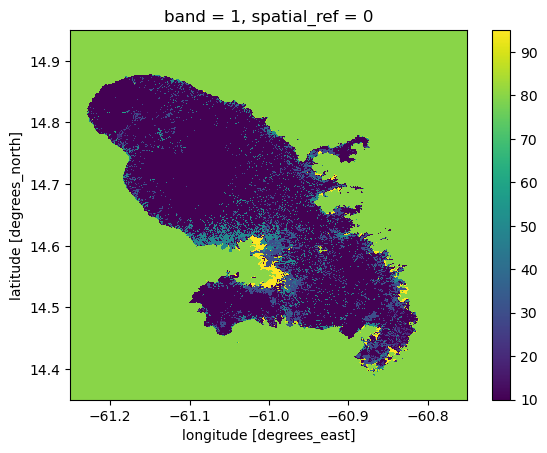

In [29]:
landcover_gross = rioxarray.open_rasterio("..\data\\raw\ESA_worldcover\ESA_WorldCover_10m_2020_v100_N12W063\ESA_WorldCover_10m_2020_v100_N12W063_Map.tif")

landcover = landcover_gross.rio.reproject_match(reference)
# Reprojection + resampling pour correspondre à la grille du raster de référence
landcover.plot()

## INSEE data

In [48]:
filosofi_vec = gpd.read_file("..\data\processed\Filosofi2017\Filosofi2017_carreaux_200m_mart.gpkg")
filosofi_vec.head(2)


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ggenelot\AppData\Local\Temp\ipykernel_40120\2824284530.py:1: SyntaxWarning: invalid escape sequence '\d'
  filosofi_vec = gpd.read_file("..\data\processed\Filosofi2017\Filosofi2017_carreaux_200m_mart.gpkg")


,Idcar_200m,I_est_200,Idcar_1km,I_est_1km,Idcar_nat,Groupe,Ind,Men_1ind,Men_5ind,Men_prop,...,Ind_25_39,Ind_40_54,Ind_55_64,Ind_65_79,Ind_80p,Ind_inc,Men_pauv,Men,lcog_geo,geometry
0,CRS5490RES200mN1592600E728800,1,CRS5490RES1000mN1592000E728000,1,CRS5490RES4000mN1592000E728000,174380,1.0,0.2,0.1,0.2,...,0.1,0.3,0.2,0.1,0.0,0.0,0.1,0.4,97226,"POLYGON ((728800 1592600, 728800 1592800, 7290..."
1,CRS5490RES200mN1594200E728800,1,CRS5490RES1000mN1594000E728000,1,CRS5490RES4000mN1592000E728000,174380,6.0,1.4,0.4,1.2,...,0.6,1.8,1.0,0.8,0.0,0.0,0.4,2.6,97226,"POLYGON ((728800 1594200, 728800 1594400, 7290..."


In [49]:
filosofi = class_vector_to_raster(filosofi_vec, "filosofi_men_prop", "Men_prop", reference)

In [52]:
filosofi.max()

<xarray.DataArray 'filosofi_men_prop' ()> Size: 8B
array(0.)

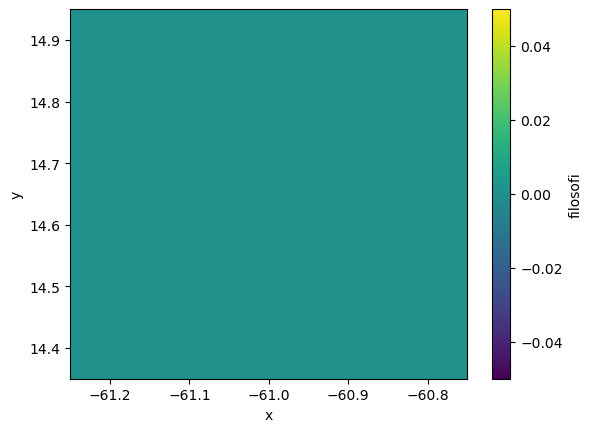

In [43]:
filosofi.plot()

## OSM data

In [14]:
buildings_vec = gpd.read_file("..\\data\\raw\OSM\\buildings.shp")
buildings_vec.head()

<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
C:\Users\ggenelot\AppData\Local\Temp\ipykernel_40120\2230429923.py:1: SyntaxWarning: invalid escape sequence '\O'
  buildings_vec = gpd.read_file("..\\data\\raw\OSM\\buildings.shp")


,element,id,addr_city,addr_postc,addr_stree,addr_house,source_geo,addr_place,addr_count,addr_hou_1,addr_full,geometry
0,relation,373384,Rivière-Salée,97215,None,BP 38,None,None,None,Quartier Thoraille,None,"POLYGON ((-60.96627 14.51354, -60.96624 14.513..."
1,relation,444734,None,None,None,None,None,None,None,None,None,"POLYGON ((-61.03895 14.63476, -61.03893 14.634..."
2,relation,444735,None,None,None,None,None,None,None,None,None,"POLYGON ((-61.03717 14.63488, -61.03718 14.634..."
3,relation,444754,None,None,None,None,None,None,None,None,None,"POLYGON ((-61.03955 14.63439, -61.03954 14.634..."
4,relation,543455,None,None,None,None,None,None,None,None,None,"POLYGON ((-61.07905 14.64925, -61.07903 14.649..."


In [38]:
buildings = vector_to_raster(buildings_vec, "buildings_test")
buildings

<xarray.DataArray 'buildings_test' (y: 2160, x: 1800)> Size: 31MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(2160, 1800))
Coordinates:
  * y        (y) float64 17kB 14.95 14.95 14.95 14.95 ... 14.35 14.35 14.35
  * x        (x) float64 14kB -61.25 -61.25 -61.25 ... -60.75 -60.75 -60.75

In [36]:
buildings

<xarray.DataArray 'buildings_test' (y: 2160, x: 1800)> Size: 31MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(2160, 1800))
Coordinates:
  * y        (y) float64 17kB 14.95 14.95 14.95 14.95 ... 14.35 14.35 14.35
  * x        (x) float64 14kB -61.25 -61.25 -61.25 ... -60.75 -60.75 -60.75

In [23]:
buildings_da

<xarray.DataArray 'classe_vecteur' (y: 2160, x: 1800)> Size: 31MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(2160, 1800))
Coordinates:
  * y        (y) float64 17kB 14.95 14.95 14.95 14.95 ... 14.35 14.35 14.35
  * x        (x) float64 14kB -61.25 -61.25 -61.25 ... -60.75 -60.75 -60.75

## Combining the dataarray in a dataset

In [ ]:
ds = xr.Dataset({
    "elevation": elevation.squeeze(drop=True),
    "buildings": buildings, 
    "landcover": landcover
})

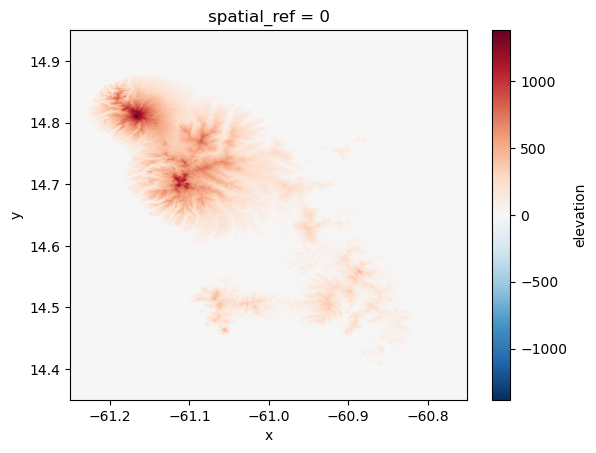

In [27]:
ds.elevation.plot()